# Data Cleaning/Wrangling for Springboard Capstone Project 1: 
## Prediction of hospital readmission rate for patients with an existing diagnosis based on factors measured at time of intial admission.
The dataset I will be using was originally constructed by researchers at Virginia Commonwealth University to see whether the decision to take a measurement of HbA1c (a test to measure glucose in diabetic patients) during hospitalization led to lower rate of hospital readmission. The HbA1c test is considered by the researchers to be a proxy for a more active management of the diabetes in the patient.  

In this analysis, I will repurpose the data set to perform a correlational analysis/ predictive modeling to determine whether one or more variables are predictive of whether or not a patient will be readmitted to the hospital within 30 days of discharge. Time allowing, the analysis may be extended to see whether prediction of readmission after 30 days can also be predicted.

In [1]:
import pandas as pd
import numpy as np

The data set, ‘Diabetes 130-US hospitals for years 1999-2008 Data Set’ is an open dataset that is obtainable at the UCI Machine Learning repository:
https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008# 

In [2]:
file = 'diabetic_data.csv'
df = pd.read_csv(file)

In [3]:
# df.sample with number of rows in parenthesis returns a random sample of values, which may be more informative than the first
# 5 rows as would be returned from df.head()
df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
65189,181680726,25428807,Caucasian,Female,[70-80),?,3,3,1,6,...,No,Steady,No,No,No,No,No,No,Yes,NO
12555,50942748,1008711,Caucasian,Male,[80-90),?,1,18,7,4,...,No,No,No,No,No,No,No,No,Yes,NO
80493,248325420,85134222,Caucasian,Male,[80-90),?,1,2,7,3,...,No,No,No,No,No,No,No,No,No,NO
3225,20268390,81001332,Caucasian,Female,[60-70),?,2,3,1,7,...,No,Down,No,No,No,No,No,Ch,Yes,>30
26031,86176170,7571295,AfricanAmerican,Female,[40-50),?,1,1,6,2,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [4]:
# Use df.info() find out the basic parameters of the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In addition to finding out that there are 50 variables and 101766 entries, we also find out that none of the columns have non-null values. This could either mean there are no missing values (unlikely) or that the missing values are denoted as either blank or some string (e.g., '?') or numeric (e.g., 0, -1) character.

In [5]:
colnames = df.columns.tolist()

In [6]:
# Show the unique values for each column as first step to identifying how missing values are shown, 
# issues with binary columns, etc.
for name in colnames:
    print(name, df[name].unique())

encounter_id [  2278392    149190     64410 ... 443854148 443857166 443867222]
patient_nbr [  8222157  55629189  86047875 ... 140199494 120975314 175429310]
race ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender ['Female' 'Male' 'Unknown/Invalid']
age ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id [6 1 2 3 4 5 8 7]
discharge_disposition_id [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedic

metformin-rosiglitazone ['No' 'Steady']
metformin-pioglitazone ['No' 'Steady']
change ['No' 'Ch']
diabetesMed ['No' 'Yes']
readmitted ['NO' '>30' '<30']


In [7]:
# Function to calculate missing values
def per_miss_val(name):
    if name in ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']:
        return (100*df.loc[:, name][df.loc[:,name]=='?'].count()/df.loc[:,name].count())
    elif name == 'gender':
        return (100*df.loc[:, name][df.loc[:,name]=='Unknown/Invalid'].count()/df.loc[:,name].count())
    else: 
        return 0.0

In [8]:
# Create a list of dictionaries where each column is a dictionary, the key is the column name, the value is a list of values.
records = []
for name in colnames:
    record = {}
  #  print(name) - used during debugging
    record['Feature Name'] = name
    record['List of Unique Values'] = df[name].unique()
    record['# of Unique Values'] = len(df[name].unique())
    record['% Missing Values'] = per_miss_val(name)
    record['First Value'] = df[name].iloc[0]
    records.append(record)
    

In [9]:
feature_df = pd.DataFrame(records)
feature_df




,# of Unique Values,% Missing Values,Feature Name,First Value,List of Unique Values
0,101766,0.000000,encounter_id,2278392,"[2278392, 149190, 64410, 500364, 16680, 35754,..."
1,71518,0.000000,patient_nbr,8222157,"[8222157, 55629189, 86047875, 82442376, 425192..."
2,6,2.233555,race,Caucasian,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
3,3,0.002948,gender,Female,"[Female, Male, Unknown/Invalid]"
4,10,0.000000,age,[0-10),"[[0-10), [10-20), [20-30), [30-40), [40-50), [..."
5,10,96.858479,weight,?,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
6,8,0.000000,admission_type_id,6,"[6, 1, 2, 3, 4, 5, 8, 7]"
7,26,0.000000,discharge_disposition_id,25,"[25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 1..."
8,17,0.000000,admission_source_id,1,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22..."
9,14,0.000000,time_in_hospital,1,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]"


# Missing Values

The next table shows only the features with missing values.

In [10]:
feature_missing = feature_df[feature_df["% Missing Values"] > 0]
feature_missing

,# of Unique Values,% Missing Values,Feature Name,First Value,List of Unique Values
2,6,2.233555,race,Caucasian,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
3,3,0.002948,gender,Female,"[Female, Male, Unknown/Invalid]"
5,10,96.858479,weight,?,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
10,18,39.557416,payer_code,?,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH..."
11,73,49.082208,medical_specialty,Pediatrics-Endocrinology,"[Pediatrics-Endocrinology, ?, InternalMedicine..."
18,717,0.020636,diag_1,250.83,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,..."
19,749,0.351787,diag_2,?,"[?, 250.01, 250, 250.43, 157, 411, 492, 427, 1..."
20,790,1.398306,diag_3,?,"[?, 255, V27, 403, 250, V45, 38, 486, 996, 197..."


Analyze each Feature with missing values and decide on a strategy. 
1. Are the missing values randomly distributed?
2. If not, is there something else in the data that the missing values are correlated with?



In [11]:
import matplotlib.pyplot as plt

## Race ##

(array([ 2273.,     0., 19210.,     0.,   641.,     0., 76099.,     0.,
         2037.,  1506.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

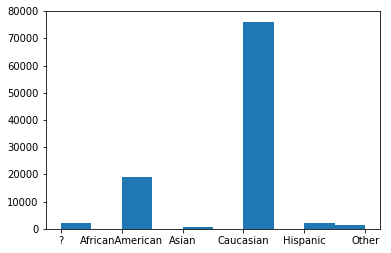

In [12]:
plt.hist(df.race)

In [13]:
for name in colnames:
    if name == 'age':
        age_uniq = list(df[name].unique())

In [14]:
age_uniq

['[0-10)',
 '[10-20)',
 '[20-30)',
 '[30-40)',
 '[40-50)',
 '[50-60)',
 '[60-70)',
 '[70-80)',
 '[80-90)',
 '[90-100)']

In [15]:
miss_dist = []
for age in age_uniq:
    miss_dist.append(len(df[(df.race == '?') & (df.age == age)]))



In [16]:
miss_ser = pd.Series(miss_dist)

In [17]:
miss_ser

0      1
1      9
2     46
3     76
4    220
5    361
6    495
7    599
8    397
9     69
dtype: int64

In [18]:
age_dist = []
for age in age_uniq:
    age_dist.append(len(df[(df.age == age)]))

In [19]:
age_ser = pd.Series(age_dist)

In [20]:
prop = miss_ser/age_ser

In [21]:
prop

0    0.006211
1    0.013025
2    0.027761
3    0.020132
4    0.022716
5    0.020920
6    0.022017
7    0.022978
8    0.023085
9    0.024705
dtype: float64

In [22]:
# Except for the two youngest age groups, the proportion is about the same.  Missing values in race seem to be evenly 
# distributed by age.
# Decision to retain the information as an 'unknown' for the race column
df.race.replace('?', 'unknown', inplace= True)

## Gender ##

In [23]:
# Very small percentage of unkown.  Replace 'Unknown/Invalid' with 'unknown'for the gender column 
# to be consistent with Race column
df.gender.replace('Unknown/Invalid', 'unknown', inplace=True)

## Weight ##

The weight variable is mostly unknown - 97% missing.  I have no reason at this point to believe that it would be crucial to the model so  I've decided to not use this variable in the analysis and remove the column. 

An explanation of why so many values are missing in this column in found in the article describing the original work: “Large percentage of missing values of the weight attribute can be explained by the fact that prior to the HITECH legislation of the American Reinvestment and Recovery Act in 2009 hospitals and clinics were not required to capture it in a structured format.” (https://www.hindawi.com/journals/bmri/2014/781670/)


In [24]:
# Decision: Drop the weight column, rename dataframe to df1
df1 = df.drop('weight',axis=1)

## Payer code ##

In [25]:
# Is there any pattern to the payer code missing features? Is there a correclation with any of the other columns?

In [26]:
# What is the most common payer code besides '?' ?  It is 'MC' (probably medicare). This can be used when ML algo is selected
# if needed.
df1.payer_code.value_counts().head()

?     40256
MC    32439
HM     6274
SP     5007
BC     4655
Name: payer_code, dtype: int64

In [27]:
# Replace the '?' with 'none' for the payer code column
df1.payer_code.replace('?', 'none', inplace = True)

## Medical Specialty ##

In [28]:
# What is the most common medical specialty besides '?' ? It is Internal Medicine. This can be used when ML algo is selected
# if needed.
df1.medical_specialty.value_counts().head()

?                         49949
InternalMedicine          14635
Emergency/Trauma           7565
Family/GeneralPractice     7440
Cardiology                 5352
Name: medical_specialty, dtype: int64

In [29]:
# Replace the '?' with 'none' for the medical specialty column
df1.medical_specialty.replace('?', 'none', inplace = True)

In [30]:
# Is a missing value in payer code correlated with a missing value in medical specialty?
# How many enocounters contain no entry for both payer code and medical specialty?
len(df1[(df1.payer_code == 'none') & (df1.medical_specialty == 'none')])

16354

In [31]:
# Do certain medical specialties have higher proportion of missing payer code?
df1_med_sp = df1.groupby(['medical_specialty','payer_code'])['payer_code'].count()
#df1_med_sp.apply(lambda x: x[x['payer_code'] == 'none'])
df1_med_sp.head()


medical_specialty     payer_code
AllergyandImmunology  MC            1
                      none          6
Anesthesiology        BC            3
                      MC            5
                      none          4
Name: payer_code, dtype: int64

In [32]:
# Looking only at the missing 'none' as True and all others as False
# Do any medical specialties have a large fraction of missing payer codes (that is, many more True than False?)
pc_missing = df1.payer_code.str.contains('none')

In [33]:
df1.groupby(['medical_specialty',pc_missing])['payer_code'].count().iloc[:25]

medical_specialty         payer_code
AllergyandImmunology      False            1
                          True             6
Anesthesiology            False            8
                          True             4
Anesthesiology-Pediatric  True            19
Cardiology                False         2389
                          True          2963
Cardiology-Pediatric      True             7
DCPTEAM                   False            6
Dentistry                 False            1
                          True             3
Dermatology               False            1
Emergency/Trauma          False         7058
                          True           507
Endocrinology             False           31
                          True            89
Endocrinology-Metabolism  False            8
Family/GeneralPractice    False         3339
                          True          4101
Gastroenterology          False          335
                          True           229
Gynecology        

In [34]:
df1.groupby(['medical_specialty',pc_missing])['payer_code'].count().iloc[25:50]

medical_specialty                     payer_code
Hematology/Oncology                   False           53
                                      True           154
Hospitalist                           False           57
InfectiousDiseases                    False           25
                                      True            12
InternalMedicine                      False         6306
                                      True          8329
Nephrology                            False          962
                                      True           651
Neurology                             False          163
                                      True            40
Neurophysiology                       False            1
Obsterics&Gynecology-GynecologicOnco  True            25
Obstetrics                            False           19
ObstetricsandGynecology               False          304
                                      True           367
Oncology                              F

In [35]:
df1.groupby(['medical_specialty',pc_missing])['payer_code'].count().iloc[51:75]

medical_specialty                  payer_code
Otolaryngology                     False          58
                                   True           67
OutreachServices                   False          12
Pathology                          True           17
Pediatrics                         False          49
                                   True          205
Pediatrics-AllergyandImmunology    True            3
Pediatrics-CriticalCare            False           2
                                   True           85
Pediatrics-EmergencyMedicine       True            3
Pediatrics-Endocrinology           False           1
                                   True          158
Pediatrics-Hematology-Oncology     True            4
Pediatrics-InfectiousDiseases      True            1
Pediatrics-Neurology               True           10
Pediatrics-Pulmonology             False           1
                                   True           24
Perinatology                       False           1


In [36]:
df1.groupby(['medical_specialty',pc_missing])['payer_code'].count().iloc[76:]

medical_specialty                 payer_code
Psychiatry                        False           297
                                  True            557
Psychiatry-Addictive              True              1
Psychiatry-Child/Adolescent       True              7
Psychology                        False            75
                                  True             26
Pulmonology                       False           336
                                  True            535
Radiologist                       False          1064
                                  True             76
Radiology                         False            20
                                  True             33
Resident                          False             1
                                  True              1
Rheumatology                      False             4
                                  True             13
Speech                            True              1
SportsMedicine                    Fal

Analysis: What stands out are the specialties where there are relatively few missing values, for example, Radiologist.
Pediatrics-Endocrinology and Pediatrics stand out for a high fraction of missing values.

Question: what more could be done at this point?

## Diagnosis Codes: 1, 2, and 3 ##
Up to three diagnoses can be made for any particular encounter.  The amount of missing values increases from diagnosis 1 to diagnosis 3 as would be expected.  Because there is predictive value to knowing that, for example, there is only one diagnosis, it makes sense to maintain the information that there is no diagnosis rather than either filling or removing the row.
Decision is to replace the '?' with 'none'.

In [37]:
# Replace the '?' with 'none' for diag_1
df1.diag_1.replace('?', 'none', inplace = True)

In [38]:
# Replace the '?' with 'none' for diag_2
df1.diag_2.replace('?', 'none', inplace = True)

In [39]:
# Replace the '?' with 'none' for diag_3
df1.diag_3.replace('?', 'none', inplace = True)

In [40]:
# Check for missing values denoted by a 0 or 1 or other unusual number in encounter_id and patient_nbg
df1.loc[:,['encounter_id', 'patient_nbr']].min()

encounter_id    12522
patient_nbr       135
dtype: int64

Encounter id and patient number appear to not have missing values of this type.

## Target Column preparation
The target column is 'readmitted'. Initially I will transform the column to binary (0 for 'No' and '>30', 1 for '<30').

Less than 30 days ('<30') is the standard for assessing what constitutes ‘hospital readmission’: CMS defines a hospital readmission as "an admission to an acute care hospital within 30 days of discharge from the same or another acute care hospital."Readmissions-Reduction-Program". www.cms.gov. 2016-02-04. Retrieved 2016-03-01.Also: https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/PhysicianFeedbackProgram/Downloads/2015-ACR-MIF.pdf

This is the criteria that makes sense for the initial mock business case discussed in the proposal.

However, I might want to extend the analysis for practice. A Kaggle competition which used the same data set (a closed competition, so no kernels posted) suggested that the expected output should include '>30' as a separate category (see https://www.kaggle.com/c/diabetes-hospital-readmission#evaluation). I will create a second column to include this as a separate category then decide whether to do multiclass analysis later on if time allows.


In [41]:
df1.readmitted.head(15)

0      NO
1     >30
2      NO
3      NO
4      NO
5     >30
6      NO
7     >30
8      NO
9      NO
10    >30
11    <30
12    <30
13     NO
14    >30
Name: readmitted, dtype: object

In [42]:
# Define a function to convert readmitted column to binary
def recode_readmit_bin(readmit_value):
    # Return 1 if readmit_value is '<30'
    if readmit_value == '<30':
        return 1
    # Return 0 if readmit_value is 'NO' or '>30'
    elif (readmit_value == 'NO')  or (readmit_value == '>30'):
        return 0
    # Return np.nan if anything else
    else:
        return np.nan
# Apply the function to the readmitted column and create new column
df1['readmit_bin'] = df1.readmitted.apply(recode_readmit_bin)
print(df1.loc[:15,['readmitted','readmit_bin']])

   readmitted  readmit_bin
0          NO            0
1         >30            0
2          NO            0
3          NO            0
4          NO            0
5         >30            0
6          NO            0
7         >30            0
8          NO            0
9          NO            0
10        >30            0
11        <30            1
12        <30            1
13         NO            0
14        >30            0
15         NO            0


In [43]:
# Check for missing values
df1.readmit_bin.isnull().sum()

0

In [44]:
# Define a function to convert readmitted column to three trinary
def recode_readmit_tri(readmit_value):
    # Return 1 if readmit_value is '<30'
    if readmit_value == '<30':
        return 1
    # Return 2 if readmit_value is '>30'
    elif readmit_value == '>30':
        return 2
    # Return 0 if readmit_value is 'NO'
    elif readmit_value == 'NO':
        return 0
    # Return np.nan if anything else
    else: 
        return np.nan

# Aplly the function to the readmitted column and create new column
df1['readmit_tri'] = df1.readmitted.apply(recode_readmit_tri)
print(df1.loc[:15,['readmitted','readmit_bin', 'readmit_tri']])



   readmitted  readmit_bin  readmit_tri
0          NO            0            0
1         >30            0            2
2          NO            0            0
3          NO            0            0
4          NO            0            0
5         >30            0            2
6          NO            0            0
7         >30            0            2
8          NO            0            0
9          NO            0            0
10        >30            0            2
11        <30            1            1
12        <30            1            1
13         NO            0            0
14        >30            0            2
15         NO            0            0


## Data Dictionary ##

To understand each variable better, I created a table showing the Feature Name, Type, and a Description of the feature.

This information was obtained by copy-pasting to Excel the table describing the features located at https://www.hindawi.com/journals/bmri/2014/781670/tab1/ which was included in the paper originally describing the data

In [45]:
data_dictionary = pd.read_csv('diabetes-data-dict2.csv')
data_dictionary

,Feature name,Type,Description and values,% missing
0,Encounter ID,Numeric,Unique identifier of an encounter,0%
1,Patient number,Numeric,Unique identifier of a patient,0%
2,Race,Nominal,"Values: Caucasian, Asian, African American, Hi...",2%
3,Gender,Nominal,"Values: male, female, and unknown/invalid",0%
4,Age,Nominal,"Grouped in 10-year intervals: 0, 10), 10, 20),...",0%
5,Weight,Numeric,Weight in pounds.,97%
6,Admission type,Nominal,Integer identifier corresponding to 9 distinct...,0%
7,Discharge disposition,Nominal,Integer identifier corresponding to 29 distinc...,0%
8,Admission source,Nominal,Integer identifier corresponding to 21 distinc...,0%
9,Time in hospital,Numeric,Integer number of days between admission and d...,0%


In [46]:
# expand row 26 so each medication is on a separate row
drugs = data_dictionary.iloc[26][2]
drugs

'For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: â€œupâ€\x9d if the dosage was increased during the encounter, â€œdownâ€\x9d if the dosage was decreased, â€œsteadyâ€\x9d if the dosage did not change, and â€œnoâ€\x9d if the drug was not prescribed'

In [47]:
# import regex library
import re

In [48]:
drug_list = re.compile('For the generic names: (.+?), the').findall(drugs)

In [49]:
drug_list2 = drug_list[0].split(', ')

In [50]:
drug_list2

['metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'sitagliptin',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'and metformin-pioglitazone']

In [51]:
drug_list2[-1] = 'metformin-pioglitazone'

In [52]:
#Create a dataframe with the drug names

df_drug = pd.DataFrame(drug_list2, columns = ["Feature name"])
df_drug.head()

,Feature name
0,metformin
1,repaglinide
2,nateglinide
3,chlorpropamide
4,glimepiride


In [53]:
# Add the description of the Feature name for each drug
drugs_desc = "the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed"

In [54]:
df_drug['Description and values'] = drugs_desc
df_drug['Type'] = 'Nominal'
df_drug

,Feature name,Description and values,Type
0,metformin,the feature indicates whether the drug was pre...,Nominal
1,repaglinide,the feature indicates whether the drug was pre...,Nominal
2,nateglinide,the feature indicates whether the drug was pre...,Nominal
3,chlorpropamide,the feature indicates whether the drug was pre...,Nominal
4,glimepiride,the feature indicates whether the drug was pre...,Nominal
5,acetohexamide,the feature indicates whether the drug was pre...,Nominal
6,glipizide,the feature indicates whether the drug was pre...,Nominal
7,glyburide,the feature indicates whether the drug was pre...,Nominal
8,tolbutamide,the feature indicates whether the drug was pre...,Nominal
9,pioglitazone,the feature indicates whether the drug was pre...,Nominal


In [55]:
data_dictionary = data_dictionary.drop('% missing', axis=1)
data_dictionary.head()

,Feature name,Type,Description and values
0,Encounter ID,Numeric,Unique identifier of an encounter
1,Patient number,Numeric,Unique identifier of a patient
2,Race,Nominal,"Values: Caucasian, Asian, African American, Hi..."
3,Gender,Nominal,"Values: male, female, and unknown/invalid"
4,Age,Nominal,"Grouped in 10-year intervals: 0, 10), 10, 20),..."


In [56]:
pd.concat([data_dictionary.iloc[:26,:],df_drug, data_dictionary.iloc[27:]], ignore_index=True)

,Description and values,Feature name,Type
0,Unique identifier of an encounter,Encounter ID,Numeric
1,Unique identifier of a patient,Patient number,Numeric
2,"Values: Caucasian, Asian, African American, Hi...",Race,Nominal
3,"Values: male, female, and unknown/invalid",Gender,Nominal
4,"Grouped in 10-year intervals: 0, 10), 10, 20),...",Age,Nominal
5,Weight in pounds.,Weight,Numeric
6,Integer identifier corresponding to 9 distinct...,Admission type,Nominal
7,Integer identifier corresponding to 29 distinc...,Discharge disposition,Nominal
8,Integer identifier corresponding to 21 distinc...,Admission source,Nominal
9,Integer number of days between admission and d...,Time in hospital,Numeric


In [57]:
# Question: How do I format the table to show the full description of the Feature (first column above)?